# Data Mining Lab 3 Pipeline Assignment

**Medium articles** are used to disseminate knowledge and are written on a wide range of technical and non-technical topics. Users subscribe to different reading lists where reading lists represent either domains or certain topics. This naturally gives rise to a network structure where articles may belong to the same reading lists and hence are related to each other. Each article belongs to a certain topic. Automatically assigning articles to topics is very valuable for search applications. **The goal of this task is to classify articles by predicting their topics.**

A dataset of medium articles along with subscription lists and topic tags is provided. The task is to classify articles into tags (i.e., topics), leveraging the network structure arising from relations using the subscription lists. Specifically, two nodes are connected if they share at least one list.

**For this task you may only use the following libraries**: `numpy`, `pandas`, `matplotlib`, `networkx`, `gensim`.


In [2]:
from collections import defaultdict
from itertools import combinations
from pathlib import Path

import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from gensim.models import Word2Vec

## Data loading

The data is provided in three files which can be found in the `data` directory:

- `articles.csv`: Contains the articles along with the subscription lists and some metadata.
- `test_data.csv`: Contains a subset of nodes (articles) along with their labels (topics) used for testing.
- `train_data.csv`: Contains the remaining nodes (articles) along with their labels (topics).

**Important**: There is no specific training data requried for this assignment, since the node embeddings (task 3) are trained on the entire graph. The nodes in `train_data.csv` must be used for the kNN classifier, i.e., the computed nearest neighbors for a test node may only be nodes from this file.

Let's use `pandas` to read these files:


In [3]:
articles = pd.read_csv(Path("data") / "articles.csv")
articles["node_id"] = articles.index
articles["lists"] = articles["lists"].str.split("; ")
test_data = pd.read_csv(Path("data") / "test_data.csv")
train_data = pd.read_csv(Path("data") / "train_data.csv")

Note that we have assigned node IDs based on where each article is located in the file.

We can now inspect the individual data frames:


In [4]:
articles.head(2)

,article,title,subtitle,author,date,lists,node_id
0,https://medium.com/@maniakacademy/code-demo-sh...,Code/Demo Share: Palo Alto Firewall Network In...,IP is broken as a unit of Control! IDENTITY as...,Sebastian Maniak,2022-08-17,[https://medium.com/@zemmali1990/list/aws-49f6...,0
1,https://medium.com/towards-artificial-intellig...,Clustering using Social Graph Network,A Social Graph Network can be formed when ther...,Naveed Ahmed Janvekar,2022-01-29,[https://medium.com/@TomaszCieplak/list/graph-...,1


In [5]:
test_data.head(2)

,node_id,label
0,2291,artificial-intelligence
1,7292,artificial-intelligence


Next, let's create our graph. We'll create one node for each article and insert an edge between two articles if they share at least one subscription list:


In [6]:
medium_graph = nx.Graph()
medium_graph.add_nodes_from(articles["node_id"].to_list())

list_to_nodes = defaultdict(set)
for _, row in articles[["node_id", "lists"]].iterrows():
    for l in row["lists"]:
        list_to_nodes[l].add(row["node_id"])

for node_ids in list_to_nodes.values():
    medium_graph.add_edges_from(combinations(node_ids, 2))

## Tasks

1. Familiarization: Analyze the graph. Compute and plot statistics such as the number of nodes, number of edges, number of neighbors of each node, and so on. Are there any isolated nodes (i.e., nodes that do not have a single neighbor)?
2. Compute spectral node embeddings.
3. Perform random walks on the graph to obtain a set of sequences of nodes. Use those sequences to compute node embeddings. Hint: You may use the Word2vec implementation of the gensim library for this task. By treating each node as a word, this method will give you node embeddings.
4. Implement a simple k-nearest neighbor classifier: For each node (medium article) in the test set, compute its nearest neighbors (based on the similarity of node embeddings). The classifier assigns a label (i.e., a topic) based on the topics of the nearest neighbors. Specifically, the predicted topic is simply the most common topic among the nearest neighbors. Compare both sets of node embeddings in terms of performance. Which one works better?


### Q1

Number of nodes: 27718
Number of edges: 2014162
Node 0 has 144 neighbors
Node 1 has 102 neighbors
Node 2 has 18 neighbors
Node 3 has 34 neighbors
Node 4 has 15 neighbors
There are 347 isolated nodes


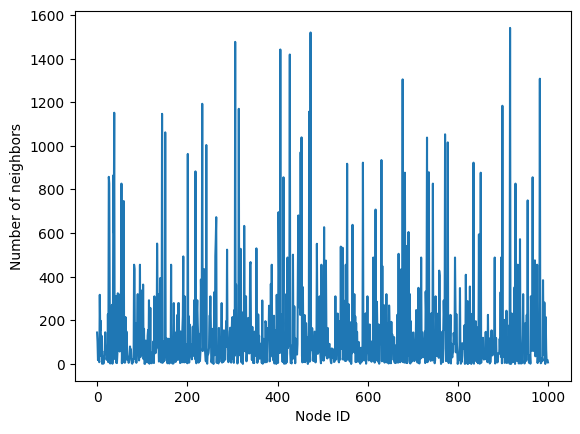

In [7]:
num_nodes = medium_graph.number_of_nodes()
print("Number of nodes:", num_nodes)
num_edges = medium_graph.number_of_edges()
print("Number of edges:", num_edges)

# Then we also print the degrees of several nodes
print_lim = 5
isolated = 0
for n in medium_graph.nodes:
    deg = medium_graph.degree(n)
    if print_lim > 0:
        print(f"Node {n} has {deg} neighbors")
        print_lim -= 1
    if deg == 0:
        isolated += 1
print(f"There are {isolated} isolated nodes")
some_nodes = list(medium_graph.nodes)[:1000]
plt.xlabel("Node ID")
plt.ylabel("Number of neighbors")
plt.plot(some_nodes, [medium_graph.degree[i] for i in some_nodes])
plt.show()

We can see that the nodes have neighbors within the tens and sometimes hundreds, up to over 1000.

### Q2

In [8]:
def compute_spectral_embeddings(graph: nx.Graph, dim: int) -> np.ndarray:
    """Perform spectral clustering on the graph and compute low-dimensional node representations.
    Does not normalize the Laplacian.

    Args:
        graph (nx.Graph): The graph.
        dim (int): The dimension of representations. This corresponds to the number of eigenvectors used.

    Returns:
        np.ndarray: Node representations (sorted by node ID, ascending), shape (num_nodes, dim).
    """
    adjacency_matrix = nx.to_numpy_array(graph, nodelist=sorted(graph.nodes))

    # make sure the matrix is symmetric
    assert (adjacency_matrix == adjacency_matrix.T).all()

    L = np.zeros(adjacency_matrix.shape)
    for i in range(adjacency_matrix.shape[0]):
        L[i][i] = np.sum(adjacency_matrix[i])
    L -= adjacency_matrix
    _, evecs = np.linalg.eigh(L)
    np.save('spectral.npy', evecs)
    return evecs[:, :dim]

## WARNING
The spectral embedding function takes 30 minutes to run on the medium graph, so we recommend that you get the result from the file _spectral.npy_

In [9]:
dim = 128
if Path('spectral.npy').exists():
    spectral_embed = np.load('spectral.npy')[:, :dim]
else:
    spectral_embed = compute_spectral_embeddings(medium_graph, dim)
spectral_embed

array([[ 0.00000000e+00,  0.00000000e+00, -6.40289374e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.85276921e-16, -1.08831230e-16, -6.40289374e-03, ...,
        -1.69494910e-17,  7.46108091e-17, -3.24551579e-17],
       [ 1.80137552e-15, -2.72364226e-16, -6.40289374e-03, ...,
        -2.77257867e-17, -3.13678747e-16, -6.13550376e-17],
       ...,
       [ 6.39730104e-17, -2.86947657e-16, -6.40289374e-03, ...,
        -8.45459584e-17,  1.39631264e-16, -7.80629799e-17],
       [-4.15669560e-16,  4.07117916e-17, -6.40289374e-03, ...,
        -1.37957103e-16, -1.63307952e-17,  9.13237042e-17],
       [-6.41008689e-04,  4.18450886e-03,  0.00000000e+00, ...,
         2.04431634e-02, -3.91007366e-03, -9.56959206e-03]])

### Q3

In [10]:
def random_walks(graph: nx.Graph, num_walks: int, walk_length: int) -> np.ndarray:
    """Perform random walks on an unweighted graph.

    Args:
        graph (nx.Graph): The graph.
        num_walks (int): The number of random walks for each node.
        walk_length (int): The number of nodes in a random walk.

    Returns:
        np.ndarray: The random walks, shape (n_nodes * num_walks, walk_length)
    """
    result = np.zeros((num_nodes * num_walks, walk_length), dtype=int)

    i = 0
    for idx, node in enumerate(graph.nodes):
        for walk in range(num_walks):
            here = node
            for j in range(walk_length):
                result[i, j] = here
                if not nx.is_isolate(graph, here):
                    here = np.random.choice(graph[here])
            i+=1

    return result

We treat isolated nodes by making them walk back to themselves. This way, they are entirely similar to themselves, and others are not similar to them at all.

In [11]:
num_walks = 20
walk_length = 5
random_walk_list = random_walks(medium_graph, num_walks, walk_length)
random_walk_list

array([[    0, 10977, 20711, 12413, 21522],
       [    0,  6052,  3000,  7336,  5780],
       [    0, 21835, 16374, 22726, 15802],
       ...,
       [27717, 21386,  8872, 23035, 23780],
       [27717, 23780, 24823, 21386, 23780],
       [27717, 23035, 27717, 23035,  8872]])

We create a Word2Vec model and we train it using these random walks as sentences.

In [12]:
model = Word2Vec(sentences=random_walk_list.tolist())
#model.build_vocab(random_walk_embed.tolist()) # building vocab cancels training, dont do it

In [13]:
#print(model.epochs)
#model.train(random_walk_embed.tolist(), total_examples=model.corpus_count, epochs=model.epochs)
random_walk_embed = model.wv.vectors

### Q4

First we convert the train and test sets into arrays that we can work with.

In [14]:
train_labels = np.empty(num_nodes, dtype=object)
for i in range(train_data.shape[0]):
    train_labels[train_data['node_id'][i]] = train_data['label'][i]
print(train_labels)

['software-development' 'artificial-intelligence'
 'artificial-intelligence' ... 'artificial-intelligence' None None]


In [15]:
test_labels = np.empty(num_nodes, dtype=object)
for i in range(test_data.shape[0]):
    test_labels[test_data['node_id'][i]] = test_data['label'][i]
print(test_labels)

[None None None ... None 'software-development' 'software-development']


For the similarity measure, we use (negative) Euclidean distance.

In [16]:
def similarity(node_a: int, node_b: int, embed: np.ndarray[float]) -> float:
    return -np.linalg.norm(embed[node_a] - embed[node_b])

Below we implement a k-NN classifier for random walk embeddings. This function takes a node, a list of known train labels for nodes, a Word2Vec model with a given vocabulary, and a _k_ parameter. It returns the most common label among the given node's most similar _k_ nodes.

In [17]:
def k_nearest_neighbors_random_walk(node_id: int, train_data: np.ndarray[str], model: Word2Vec, k: int) -> str:
    counts = {}
    for neighbor in model.wv.most_similar(node_id)[:k]:
        label = train_data[neighbor[0]]
        counts[label] = counts.get(label, 0) + 1
    max_count = 0
    label = None
    for l in counts:
        if counts[l] > max_count:
            max_count = counts[l]
            label = l
    return label

Below we implement a k-NN classifier for general purpose. It takes the node id, the train labels of all nodes, their embeddings (spectral or random walk) and the _k_ parameter. It returns the most common label among the closest _k_ neighbors within the embedding space.

In [18]:
import heapq

def k_nearest_neighbors(node_id: int, train_data: np.ndarray[str], embed: np.ndarray[float], k: int) -> str:
    dists: list[(float, int)] = [(similarity(i, node_id, embed), i) for i in range(k)]
    heapq.heapify(dists)
    for i in range(k, train_data.shape[0]):
        d = similarity(i, node_id, embed)
        m = dists[0][0]
        if d > m:
            heapq.heapreplace(dists, (d, i))
    counts = {}
    max_count = 0
    label = None
    for pair in dists:
        l = train_data[pair[1]]
        c = counts.get(l, 0) + 1
        if c > max_count:
            max_count = c
            label = l
        counts[l] = c
    return label

We tune the _k_ parameter by taking several values and plotting the fraction of correct guesses for each.

In [19]:
k_list = list(range(1, 21))
accuracies = []
validation_size = int(0.4 * num_nodes) # percentage of train set that we use as validation set
for k in k_list:
    validation_nodes = np.random.choice(range(num_nodes), size=validation_size)
    correct = 0
    for node in validation_nodes:
        guessed_label = k_nearest_neighbors_random_walk(node, train_labels, model, k)
        if guessed_label == train_labels[node]:
            correct += 1
    accuracies.append(correct / validation_size)
plt.xticks(k_list)
plt.xlabel('k (nearest neighbors)')
plt.ylabel('Accuracy')
plt.plot(k_list, accuracies)
plt.show()

KeyboardInterrupt: 

Evaluating accuracy on the test set

In [20]:
def test_accuracy(embed: np.ndarray[float], k: int = 10) -> float:
    correct = 0
    total = 0
    for i, label in enumerate(test_labels):
        if i % 100 == 0:
            print(i) # progress bar
        if label:
            total += 1
            guessed_label = k_nearest_neighbors(i, train_labels, embed, k)
            if guessed_label == label:
                correct += 1
    return correct / total

WARNING: on the spectral embeds it takes 5 minutes

In [21]:
print(test_accuracy(spectral_embed))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18